<ipython-input-3-df8bb314a1d6>:68: RuntimeWarning: overflow encountered in double_scalars
  mag[y][x] = numpy.math.sqrt(X[y][x] * X[y][x] + Y[y][x] * Y[y][x])
<ipython-input-3-df8bb314a1d6>:69: RuntimeWarning: invalid value encountered in double_scalars
  degree[y][x] = atan(Y[y][x]/X[y][x])
<ipython-input-3-df8bb314a1d6>:69: RuntimeWarning: divide by zero encountered in double_scalars
  degree[y][x] = atan(Y[y][x]/X[y][x])


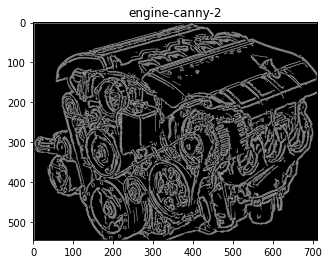

In [3]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy
import scipy.stats as st
from math import atan
from math import degrees

K = 3

def getWidth(imageArray):
    return len(imageArray[0])

def getHeight(imageArray):
    return len(imageArray)

def getGrayScaledPixel(rgbPixel):
    return 0.2126 * rgbPixel[0] + 0.7152 * rgbPixel[1] + 0.0722 * rgbPixel[2]

def convertToGrayScale(imageArray):
    width = getWidth(imageArray)
    height = getHeight(imageArray)
    result = numpy.empty([height, width])
    for x in range(0, height):
        for y in range(0, width):
            result[x][y] = getGrayScaledPixel(imageArray[x][y])
    return result

def gkern(kernlen=21, nsig=30):
    interval = (2*nsig+1.)/(kernlen)
    x = numpy.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = numpy.diff(st.norm.cdf(x))
    kernel_raw = numpy.sqrt(numpy.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def GaussianCoefficients(sigma):
    return gkern(2*K+1,sigma)

def getSx():
    return numpy.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

def getSy():
    return numpy.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

def calculateFilterValue(kernel, pixel, k):
    total = 0
    for x in range(0, 2*k+1):
        for y in range(0, 2*k+1):
            total = total + kernel[x][y]*pixel[x][y]
    return total

def filter(kernel, imageArray, k):
    width = getWidth(imageArray)
    height = getHeight(imageArray)
    result = numpy.empty([height - 2*k, width - 2*k])
    for x in range(k, width -2*k):
        for y in range(k, height -2*k):
            result[y][x] = calculateFilterValue(kernel, imageArray[y-k:y+k+1,x-k:x+k+1], k)
    return result

def calculateMagnituteAndDegree(X, Y):
    width = getWidth(X)
    height = getHeight(X)
    mag = numpy.empty([height, width])
    degree = numpy.empty([height, width])
    for x in range(0, width):
        for y in range(0, height):
            mag[y][x] = numpy.math.sqrt(X[y][x] * X[y][x] + Y[y][x] * Y[y][x])
            degree[y][x] = atan(Y[y][x]/X[y][x])
    degree = (numpy.round(degree * (5.0 / numpy.pi)) + 5) % 5
    return mag, degree

def nonMaximalSupress(image,gdegree):
    width = getWidth(image)
    height = getHeight(image)
    for x in range(0,width):
        for y in range(0,height):
            if x == 0 or y == height -1 or y == 0 or x == width -1:
                image[y][x] = 0
                continue
            direction = gdegree[y][x] % 4
            if direction == 0:
                if image[y][x] <= image[y][x-1] or image[y][x] <= image[y][x+1]:
                    image[y][x] = 0
            if direction == 1:
                if image[y][x] <= image[y-1][x+1] or image[y][x] <= image[y+1][x-1]:
                    image[y][x] = 0
            if direction == 2:
                if image[y][x] <= image[y-1][x] or image[y][x] <= image[y+1][x]:
                    image[y][x] = 0
            if direction == 3:
                if image[y][x] <= image[y-1][x-1] or image[y][x] <= image[y+1][x+1]:
                    image[y][x] = 0
    return image

def doubleThreshold(image, lowThreshold, highThreshold):
    image[numpy.where(image > highThreshold)] = 255
    image[numpy.where((image >= lowThreshold) & (image <= highThreshold))] = 75
    image[numpy.where(image < lowThreshold)] = 0
    return image

def edgeTracking(image):
    width = getWidth(image)
    height = getHeight(image)
    for i in range(0, height):
        for j in range(0, width):
            if image[i][j] == 75:
                if ((image[i+1][j] == 255) or (image[i - 1][j] == 255) or (image[i][j + 1] == 255) or (image[i][j - 1] == 255) or (image[i+1][j + 1] == 255) or (image[i-1][j - 1] == 255)):
                    image[i][j] = 255
                else:
                    image[i][j] = 0
    return image

def cannyEdgeDetector(src, sigma, lowThreshold, highThreshold):
    image = PIL.Image.open(src)
    pixel = numpy.array(image)
    if len(pixel.shape) == 3:
        output = convertToGrayScale(pixel)
    else:
        output = pixel.copy()
    output = filter(GaussianCoefficients(sigma), output, K)
    output = output.astype(int)
    sx = filter(getSx(), output, 1)
    sy = filter(getSy(), output, 1)
    gradientMagnitute, gradientdegree = calculateMagnituteAndDegree(sx, sy)
    supressed = nonMaximalSupress(gradientMagnitute, gradientdegree)
    thresholded = doubleThreshold(supressed, lowThreshold, highThreshold)
    output = edgeTracking(thresholded)
    return output

cannyImage = cannyEdgeDetector('engine.jpg', 1, 20, 40)

plt.figure()
plt.title('engine-canny-2')
plt.imsave('engine-canny-2.png', cannyImage, cmap='gray', format='png')
plt.imshow(cannyImage, cmap='gray')
plt.show()